Declare whether the runtime is local or global

In [0]:
########################################################

# Specify whether to run using local or remote runtime
# to start a local runtime: jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
# NOTE: supported local runtimes are [Linux]

LOCAL_RUNTIME = False

Install Tensorflow Addons - necessary to perform a weight decay using the Adam optimizer

In [2]:
pip install tensorflow-addons

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 55.7MB/s 
     |████████████████████████████████| 450kB 54.4MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Su

In [3]:
pip uninstall keras -y

Uninstalling Keras-2.2.5:
  Successfully uninstalled Keras-2.2.5


In [4]:
pip install keras

     |████████████████████████████████| 378kB 2.8MB/s 


Run the program:

In [5]:
# to run continually (without 'check-in'), type the following in console (cntrl+shift+i):
# function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,600000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
import pickle

import keras
from keras.models import Model, Sequential
from keras.layers import Layer, Conv2D, BatchNormalization, Input, Reshape, ZeroPadding2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_addons as tfa

import scipy.ndimage
from scipy import fftpack
import scipy.io as sio

from pathlib import Path
import cv2
import os
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm import tqdm

Using TensorFlow backend.


In [6]:
########################################################

# If running with Google Colab

if not LOCAL_RUNTIME:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# network specifications
image_shape = (256, 256, 3) # image_shape: shape of images we will crop to. Also controls whether we are dealing with black or white images
n = 5                       # n: number of layers per CNN network (1 CNN network per iteration)
N = 8                       # N: number of iterations
normalize = True            # normalize: uses [0, 1] scale if True, else uses [0, 255] (raw pixel range)
batchnorm_at_end = False    # batchnorm_at_end: uses a single BatchNormalization layer at the end of the CNN block if True, else uses a BatchNormalization layer after every CNN layer
proximal_enabled = True     # proximal_enabled: inserts the ProximalGradient layer into the network if True, else leaves these layers out (pure CNN at that point)
use_sigmoid = False         # use_sigmoid: puts a Sigmoid activation on the last exposed layer of the CNN network if True
if use_sigmoid and not normalize:
  print('WARNING: normalize should be True if use_sigmoid is True')

# prior specifications
sigma = 1.6
C_0 = 1000
C_k = 1
weight_decay = 0.0001
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999

# augmentation specs
noise_sigma = 5.7020        # aug_sigma: std dev of the amount of Gaussian noise to add to the image during training
blur_name = 'motion'        # blur_name: name of the type of blur kernel to use during training (disk, motion)
assert blur_name == 'disk' or blur_name == 'motion'

# define training variables
epochs = 300
batch_size = 4
workers = 10
use_multiprocessing = True

In [8]:
########################################################

# Set up save directories

if LOCAL_RUNTIME:
    main_dir = "./"
else:
    main_dir = "/content/gdrive/My Drive/239ASCompImagingData/"
    
model_prefix = 'deblurring-{}'.format(blur_name)

save_dir = os.path.join(main_dir, 'runs')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

prefix_dir = os.path.join(save_dir, model_prefix)
if not os.path.exists(prefix_dir):
    os.mkdir(prefix_dir)

# create a unique name for the model:
runs = len(os.listdir(prefix_dir))
print('Model: {}, run: {}'.format(model_prefix, runs+1))
run_name = 'run-' + str(runs+1)

runs_dir = os.path.join(prefix_dir, run_name)
if not os.path.exists(runs_dir):
    os.mkdir(runs_dir)

logs_dir = os.path.join(runs_dir, 'log')
if not os.path.exists(logs_dir):
    os.mkdir(logs_dir)
    
model_dir = os.path.join(runs_dir, 'model')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

figs_dir = os.path.join(runs_dir, 'figs')
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)


Model: deblurring-motion, run: 19


In [0]:
########################################################

# If running with Google Colab
# File directory is as follows

# !ls "/content/gdrive/My Drive/239ASCompImagingData"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/train"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/test"
# !ls "/content/gdrive/My Drive/239ASCompImagingData/images/val"

if LOCAL_RUNTIME:
    # if running locally, use the full path to BSR: 'BSR/BSDS500/data/images'
    dataset_dir = 'BSR/BSDS500/data/images'
else:
    # if running with Google Colab, use 'images' as main folder
    dataset_dir = 'images'

train_dir = Path(os.path.join(main_dir, dataset_dir, "train"))
test_dir = Path(os.path.join(main_dir, dataset_dir, "test"))
val_dir = Path(os.path.join(main_dir, dataset_dir, "val"))

# noisy_train_dir = Path("/content/gdrive/My Drive/239ASCompImagingData/images_blurry/train") # no longer used
noisy_test_dir = Path(os.path.join(main_dir, "images_blurry_{}/test".format(blur_name)))
# noisy_val_dir = Path("/content/gdrive/My Drive/239ASCompImagingData/images_blurry/val")

In [0]:
########################################################

# Save configuration to file

with open(os.path.join(runs_dir, "description.txt"),"w") as fileobj:
    fileobj.writelines(l for l in ["\n---\nruntime specifications\n---\n",
                                   "LOCAL_RUNTIME = {}\n".format(LOCAL_RUNTIME),
                                   "\n---\ndirectory specifications\n---\n",
                                   "main_dir = {}\n".format(main_dir),
                                   "train_dir = {}\n".format(train_dir),
                                   "test_dir = {}\n".format(test_dir),
                                   "val_dir = {}\n".format(val_dir),
                                   "noisy_test_dir = {}\n".format(noisy_test_dir),
                                   "runs_dir = {}\n".format(runs_dir),
                                   "logs_dir = {}\n".format(logs_dir),
                                   "model_dir = {}\n".format(model_dir),
                                   "figs_dir = {}\n".format(figs_dir),
                                   "\n---\nnetwork specifications\n---\n",
                                   "image_shape = {}\n".format(image_shape),
                                   "n = {}\n".format(n), 
                                   "N = {}\n".format(N),
                                   "normalize = {}\n".format(normalize),
                                   "batchnorm_at_end = {}\n".format(batchnorm_at_end),
                                   "proximal_enabled = {}\n".format(proximal_enabled),
                                   "use_sigmoid = {}\n".format(use_sigmoid),
                                   "\n---\nprior specifications\n---\n",
                                   "sigma = {}\n".format(sigma),
                                   "C_0 = {}\n".format(C_0),
                                   "C_k = {}\n".format(C_k),
                                   "weight_decay = {}\n".format(weight_decay),
                                   "learning_rate = {}\n".format(learning_rate),
                                   "beta_1 = {}\n".format(beta_1),
                                   "beta_2 = {}\n".format(beta_2),
                                   "\n---\naugmentation specifications\n---\n",
                                   "noise_sigma = {}\n".format(noise_sigma),
                                   "blur_name = {}\n".format(blur_name),
                                   "\n---\ntraining specifications\n---\n",
                                   "epochs = {}\n".format(epochs),
                                   "batch_size = {}\n".format(batch_size),
                                   "workers = {}\n".format(workers),
                                   "use_multiprocessing = {}\n".format(use_multiprocessing)
                                   ])

In [0]:
########################################################

# Image processing:

# Function to display images
def showImage(image, title="", normalized=False, saveto=None, renormalize=False):
    image_copy = copy.deepcopy(image)
    if renormalize:
      # ensure the range of numbers is from 0 to 1:
      max_val = image_copy.max()
      image_copy /= max_val

    # if normalized, then undo normalization:
    if normalized or renormalize:
        image_copy = 255 * image_copy
        # ensure image_copy is between [0, 255]:
        image_copy = np.maximum(np.minimum(image_copy, 255), 0)
        image_copy = image_copy.astype(np.uint8)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image_copy.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title(title)
    if saveto is not None:
        plt.savefig(saveto)
    plt.show()
    plt.clf()

Blur kernel loaded: motion - (11, 19)


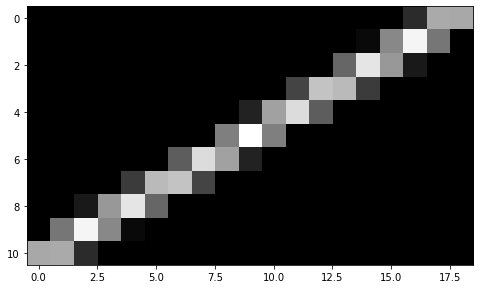

<Figure size 432x288 with 0 Axes>

In [12]:
########################################################

# Import blur kernel:

if blur_name is not None:
  loaded_mat = sio.loadmat(os.path.join(main_dir, "kernels/{}.mat".format(blur_name)))
  blur_kernel = loaded_mat['h_{}'.format(blur_name)]
  # repeat across channels:
  # blur_kernel = blur_kernel[..., np.newaxis]
  # blur_kernel = np.repeat(blur_kernel, image_shape[2], axis=-1)
  print("Blur kernel loaded: {} - {}".format(blur_name, blur_kernel.shape))
  showImage(blur_kernel, normalized=True, renormalize=True)
else:
  blur_kernel = None

In [13]:
# Create dict to hold (ground truth) images

images = {
  'train':[],
  'test':[],
  'val':[]
}

# Add images to the dict

for image in tqdm(sorted(os.listdir(train_dir))):
  if '.jpg' in image: # only add .jpg files
    images['train'] += [cv2.imread(str(train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(test_dir))):
  if '.jpg' in image: # only add .jpg files
    images['test'] += [cv2.imread(str(test_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(val_dir))):
  if '.jpg' in image: # only add .jpg files
    images['val'] += [cv2.imread(str(val_dir) + "/" + image)]

100%|██████████| 101/101 [00:43<00:00,  2.34it/s]


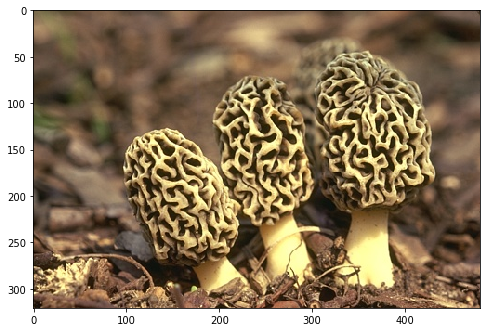

(321, 481, 3)


<Figure size 432x288 with 0 Axes>

In [14]:
showImage(images['test'][90])
print(images['test'][90].shape)

In [15]:
# Create dict to hold (noisy) images

images_noisy = {
  'train':[],
  'test':[],
  'val':[]
}

# Add images to the dict

# blurry train images are no longer used:
# for image in tqdm(sorted(os.listdir(noisy_train_dir))):
#   if '.jpg' in image: # only add .jpg files
#     images_noisy['train'] += [cv2.imread(str(noisy_train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(noisy_test_dir))):
  if '.jpg' in image: # only add .jpg files
    images_noisy['test'] += [cv2.imread(str(noisy_test_dir) + "/" + image)]

# blurry val images are no longer used:
# for image in tqdm(sorted(os.listdir(noisy_val_dir))):
#   if '.jpg' in image: # only add .jpg files
#     images_noisy['val'] += [cv2.imread(str(noisy_val_dir) + "/" + image)]

100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


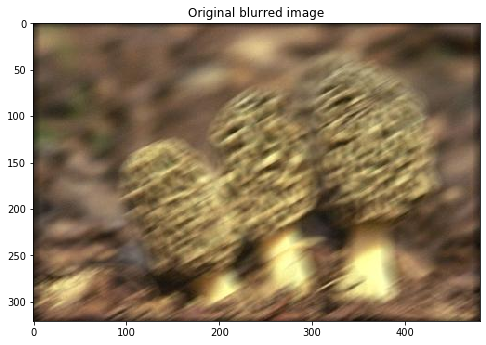

(321, 481, 3)


<Figure size 432x288 with 0 Axes>

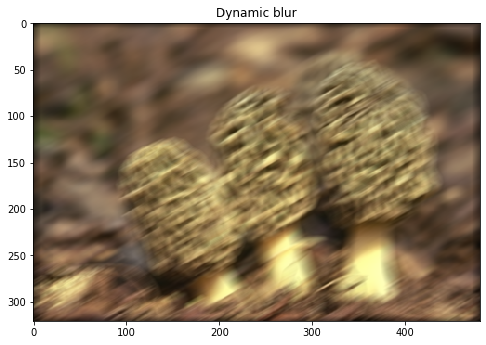

<Figure size 432x288 with 0 Axes>

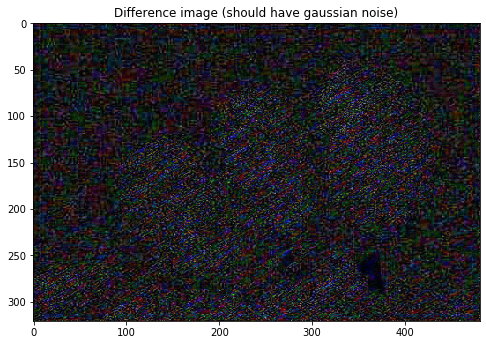

(321, 481, 3)


<Figure size 432x288 with 0 Axes>

In [16]:
showImage(images_noisy['test'][90], title='Original blurred image')
print(images_noisy['test'][90].shape)

# test imgaug noise characteristics:
double_check = [scipy.ndimage.convolve(images['test'][90][..., c].astype('float32'), blur_kernel, mode='constant') for c in range(images['test'][90].shape[2])]
double_check = np.stack(double_check)
double_check = np.moveaxis(double_check, 0, -1)
showImage(double_check, title='Dynamic blur')
diff = np.abs(images_noisy['test'][90] - double_check)
showImage(diff, title='Difference image (should have gaussian noise)', renormalize=True)
print(double_check.shape)

In [0]:
########################################################

# Custom Keras Data Generators:

# if local, we need to import the generator to make it serializable:
if LOCAL_RUNTIME:
    from image_generator import ImageGenerator
else:
    class ImageGenerator(keras.utils.Sequence):
        'Generates data for Keras'

        def __init__(self, x_path, y_path, batch_size, sigma_=0, blur_kernel_=None, crop_size=180, augment=True,
                    shuffle=True, seed=42, normalize=False):
            'Initialization'
            self.x_path = x_path
            self.y_path = y_path
            self.batch_size = batch_size
            self.augment = augment
            self.shuffle = shuffle
            np.random.seed(seed)
            self.seed = seed
            self.sigma = sigma_
            self.blur_kernel = blur_kernel_
            self.normalize = normalize

            # generate the list of images available from x_path
            self.x_image_names = self.get_image_names(self.x_path)
            self.y_image_names = self.get_image_names(self.y_path)

            # for this case, the file names in each path should equal one another:
            assert [os.path.basename(path) for path in self.x_image_names] == \
                [os.path.basename(path) for path in self.y_image_names]

            # convert x_image_names and y_image_names to np arrays for easy indexing
            self.x_image_names = np.array(self.x_image_names)
            self.y_image_names = np.array(self.y_image_names)

            # determine total images in our generator
            self.total_images = len(self.x_image_names)

            self.indexes = []
            self.on_epoch_end()

            # Augmentation pipeline:
            # Crop to width/height
            self.crop = iaa.Sequential([
                iaa.CropToFixedSize(width=crop_size, height=crop_size, position="uniform"),
            ])
            # Flip images sometimes
            self.flip = iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ])
            # Rotate the image in a 90 degree interval 75% of the time
            self.rotate_sometimes = iaa.OneOf([
                iaa.Rot90(0),
                iaa.Rot90(1),
                iaa.Rot90(2),
                iaa.Rot90(3)
            ])
            # Add White Gaussian noise
            self.add_noise = iaa.Sequential([
                iaa.AdditiveGaussianNoise(scale=self.sigma)
            ])

        @staticmethod
        def get_image_names(src_path):
            raw = sorted(os.listdir(src_path))
            return [os.path.join(src_path, name) for name in raw if '.jpg' in name]

        def on_epoch_end(self):
            'Updates indexes after each epoch'
            self.indexes = np.arange(self.total_images, dtype=np.int32)
            if self.shuffle:
                np.random.shuffle(self.indexes)

        def __len__(self):
            'Denotes the number of batches per epoch'
            assert int(np.floor(self.total_images / self.batch_size)) > 0
            return int(np.floor(self.total_images / self.batch_size))

        def __getitem__(self, index):
            'Generate one batch of data'
            # Generate indexes of the batch
            indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

            # Generate data
            x_aug, y_aug = self.__data_generation(indexes)

            return x_aug, y_aug

        def __data_generation(self, indexes):
            'Generates data containing batch_size samples'

            # pull in ONLY the images we need
            x_ = [cv2.imread(im_path) for im_path in self.x_image_names[indexes]]
            y_ = [cv2.imread(im_path) for im_path in self.y_image_names[indexes]]

            if self.augment:
                # perform augmentations on x:
                ia.seed(self.seed)
                # (1) rotate
                x_ = self.rotate_sometimes(images=x_)
                # (2) flip
                x_ = self.flip(images=x_)
                # (2.5) blur (prior to cropping)
                if self.blur_kernel is not None:
                    x_ = [self.apply_blur(x.astype('float32')) for x in x_]
                # (3) crop
                # ia.seed(self.seed)
                x_ = self.crop(images=x_)
                # (3.5) add noise
                if self.sigma > 0:
                    x_ = self.add_noise(images=x_)

                # perform augmentations on y:
                ia.seed(self.seed)
                # (1) rotate
                y_ = self.rotate_sometimes(images=y_)
                # (2) flip
                y_ = self.flip(images=y_)
                # (3) crop
                # ia.seed(self.seed)
                y_ = self.crop(images=y_)

            x_ = np.array(x_)
            y_ = np.array(y_)

            # normalize inputs from 0-255 to 0.0-1.0
            if self.normalize:
                x_ = x_.astype('float32')
                x_ = x_ / 255.0

                y_ = y_.astype('float32')
                y_ = y_ / 255.0

            # update to use new seed next time
            self.seed = np.random.randint(1, 100000)

            return x_, y_

        def apply_blur(self, x):
            x_blurred = [scipy.ndimage.convolve(x[..., c], self.blur_kernel, mode='constant') for c in range(x.shape[2])]
            x_blurred = np.stack(x_blurred)
            x_blurred = np.moveaxis(x_blurred, 0, -1)
            return x_blurred

In [0]:
########################################################

# Custom Keras Layers:

# C_0 layer (stores the shared C_0 weight)
class C0(Layer):
    C_0 = None
    kernel_c0 = None

    def __init__(self, C_0, **kwargs):
        self.C_0 = C_0
        super(C0, self).__init__(**kwargs)

    def build(self, _):
        self.kernel_c0 = self.add_weight(name='kernel_c0', shape=(1,), initializer='zeros', trainable=True)
        super(C0, self).build(_)

    def call(self, _):
        return self.kernel_c0 + self.C_0

    def compute_output_shape(self, _):
        return (1,)


# Proximal gradient layer
class ProximalGradient(Layer):
  '''
  Uses Fourier image as input
  '''

  C_k = None
  kernel_ck = None
  kernel_fft = None
  kernel_det_sq = None

  def __init__(self, blur_kernel, image_shape, C_k, verbose=False, **kwargs):
    self.C_k = C_k
    self.image_shape = image_shape

    ## Determine K
    kernel = blur_kernel
    if verbose:
      showImage(kernel, normalized=normalize, renormalize=True, 
                title="Blur kernel",
                saveto=os.path.join(figs_dir, 'blur_kernel'))
    # kernel = np.ones((10,10)) / 10**2

    ## make a Fourier version of the kernel:

    # the (constant) blur kernel in the Fourier domain. Requires input self.image_shape
    kernel_pad = self.pad_kernel(kernel)
    if verbose:
      showImage(kernel_pad, normalized=normalize, renormalize=True, 
                title="Padded kernel, with ifft shift",
                saveto=os.path.join(figs_dir, 'blur_kernel_padded'))
    # print(kernel_pad.shape)

    # make into a K variable
    kernel_pad_var = K.variable(kernel_pad)
    # print(kernel_pad.shape)

    # take the fft of this variable
    self.kernel_fft = self.keras_fft(kernel_pad_var)
    # print(self.kernel_fft.shape)
    # print('---')

    # pre-calc |K|**2 (repeat for image_shape[0]):
    raw_fft = fftpack.fft2(kernel_pad, axes=(0, 1)) # (256, 256, 3)
    if verbose:
      showImage(raw_fft, normalized=normalize, renormalize=True, 
                title="K",
                saveto=os.path.join(figs_dir, 'K'))
      showImage(np.absolute(raw_fft), normalized=normalize, renormalize=True, 
                title="||K||",
                saveto=os.path.join(figs_dir, 'K_abs'))

    abs_k = np.absolute(raw_fft) # (256, 256, 3)

    # det_k = np.array([np.linalg.det(np.moveaxis(raw_fft, -1, 0))[0]]) # determine will be the same for all 3 axes

    # abs_sq_list = [np.array(np.dot(np.matrix(raw_fft[..., c]).getH(), np.matrix(raw_fft[..., c]))) for c in range(self.image_shape[2])] # [(256, 256), (256, 256), (256, 256)]
    # abs_sq_stack = np.stack(abs_sq_list) # (3, 256, 256)
    # abs_sq = np.moveaxis(abs_sq_stack, 0, -1) # (256, 256, 3)
    abs_sq = abs_k ** 2
    if verbose:
      # print(abs_sq)
      showImage(abs_sq, normalized=normalize, renormalize=True, 
                title="|K|**2",
                saveto=os.path.join(figs_dir, 'K_sq'))
      showImage(np.absolute(abs_sq), normalized=normalize, renormalize=True, 
                title="||(|K|**2)||",
                saveto=os.path.join(figs_dir, 'K_sq_abs'))

    # determinant for both our cases is zero! It's faster to hardcode the solution

    # self.kernel_det_sq = K.variable(det_sq)
    # self.kernel_det_sq = tf.dtypes.cast(self.kernel_det_sq, dtype=tf.complex64)

    self.kernel_abs_sq = K.variable(abs_sq)
    self.kernel_abs_sq = tf.dtypes.cast(self.kernel_abs_sq, dtype=tf.complex64)
    # NEEDED --> turn into (3, 256, 256)
    self.kernel_abs_sq = K.permute_dimensions(self.kernel_abs_sq, (2,0,1)) # (3, 256, 256)

    # raise Exception('..')

    super(ProximalGradient, self).__init__(**kwargs)

  # Pad kernel and get it in the right shape for FT.
  def pad_kernel(self, kernel):
    sz = (self.image_shape[0] - kernel.shape[0], self.image_shape[1] - kernel.shape[1])  # total amount of padding
    kernel_pad = np.pad(kernel, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2, sz[1]//2)), 'constant')
    # print(kernel_pad.shape)

    # shift the kernel
    kernel_pad = fftpack.ifftshift(kernel_pad)
    # print(kernel_pad.shape)

    # duplicate for the particular number of channels we are dealing with (3, or 1):
    kernel_pad = kernel_pad[..., np.newaxis]
    # print(kernel_pad.shape)
    kernel_pad = np.repeat(kernel_pad, self.image_shape[2], axis=-1) # (:, :, 3)
    # print(kernel_pad.shape)
    return kernel_pad

  @staticmethod
  def keras_fft(tensor):
    if len(tensor.shape) > 3:
      # reshape to have last 2 dims be what we want in the FFT
      t_3 = K.permute_dimensions(tensor, (0,3,1,2))
    else:
      # reshape to have last 2 dims be what we want in the FFT
      t_3 = K.permute_dimensions(tensor, (2,0,1))
    return tf.signal.fft2d(tf.dtypes.cast(t_3, dtype=tf.complex64))

  def build(self, input_shape):
    self.kernel_ck = self.add_weight(name='kernel_ck', shape=(1,), initializer='zeros', trainable=True)
    super(ProximalGradient, self).build(input_shape)

  def call(self, inputs):
    '''
    inputs: [
      x_k: the image after previous ProximalGradient layer
      x_k_12: the image after previous CNN layer
      y: the input image (unfiltered)
      c0: the C_0 layer storing the global C_0 weight
    ]
    '''
    x_k, x_k_12, y, c0 = inputs

    # determine alpha_k
    alpha_k = c0 * (self.kernel_ck + self.C_k)
    # cast as complex64 to enable operations with Fourier variables
    alpha_k = tf.dtypes.cast(alpha_k, dtype=tf.complex64)

    # # take the FFT of x_k:
    x_k_fft = self.keras_fft(x_k)
    # print(x_k_fft.shape)

    # take the FFT of cnn_net:
    x_k_12_fft = self.keras_fft(x_k_12)
    # print(x_k_12_fft.shape)

    # take the FFT of y:
    y_fft = self.keras_fft(y)
    # print(y_fft.shape)

    # x_k, x_k_12, and y are all now in the Fourier domain

    ### Main Operation:
    KY = tf.math.multiply(self.kernel_fft, y_fft)
    # print('KY:', KY.shape)
    # S = tf.math.reciprocal(tf.math.multiply(alpha_k, tf.math.multiply(self.kernel_fft, self.kernel_fft)) + 1)
    # S = tf.math.reciprocal(alpha_k*tf.math.multiply(self.kernel_fft, tf.math.conj(self.kernel_fft)) + 1)
    S = tf.math.reciprocal(alpha_k*self.kernel_abs_sq + 1)
    # print(S.shape)
    x_k_1_fft = tf.math.multiply(S, tf.math.multiply(alpha_k, KY) + x_k_fft + x_k_12_fft)
    # print(x_k_1_fft.shape)
    ###

    # take the iFFT of x_k_1:
    x_k_1_3 = tf.signal.ifft2d(x_k_1_fft)
    # print(x_k_1_3.shape)

    # re-permute to get channels-last format
    x_k_1 = K.permute_dimensions(x_k_1_3, (0,2,3,1))
    # print(x_k_1.shape)

    return tf.dtypes.cast(x_k_1, dtype=K.floatx())

  def take_diag(self, diagonal):
    '''
    diagonal: (3, 256, 256) input that we want to take the diagonal component of
    '''
    # METHOD 1:
    # make I:
    eye = tf.eye(self.image_shape[0], batch_shape=[self.image_shape[2]]) # (3, 256, 256)
    eye = tf.dtypes.cast(eye, dtype=tf.complex64)
    kernel_diag = tf.multiply(diagonal, eye) # (3, 256, 256)

    return kernel_diag

  def compute_output_shape(self, input_shape):
    # assert isinstance(input_shape, list)
    return input_shape

Build the CNN part of the algorithm:

In [0]:
########################################################

# Custom Vanilla Layers:

def createCNN(input_, weight_decay, n=7, batchnorm_at_end=False):
    # initial input layer
    layers = input_

    # Add the n-2 conv layers with 64 channels
    for n_ in range(n - 1):
        if n_ == 0:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)
        else:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)

    # Add the conv layer with 3 channels
    layers = Conv2D(3, kernel_size=(3, 3), activation='softmax' if use_sigmoid else 'relu', padding='same')(layers)
    if batchnorm_at_end:
        layers = BatchNormalization(axis=-1)(layers)

    return layers

Tie the CNN network(s) with the proximal gradient layers

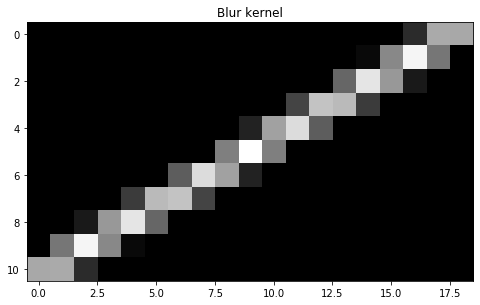

<Figure size 432x288 with 0 Axes>

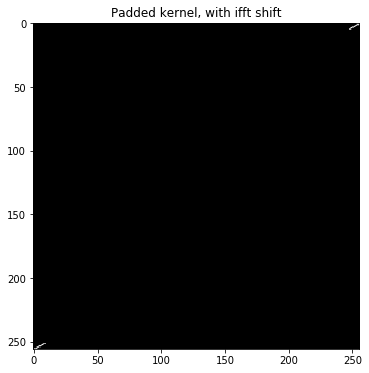

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


<Figure size 432x288 with 0 Axes>

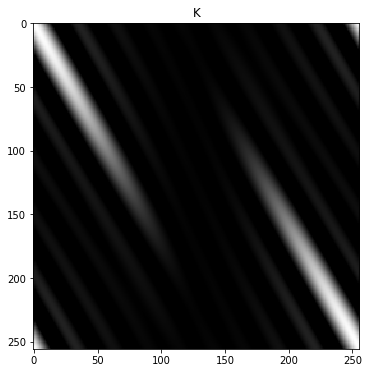

<Figure size 432x288 with 0 Axes>

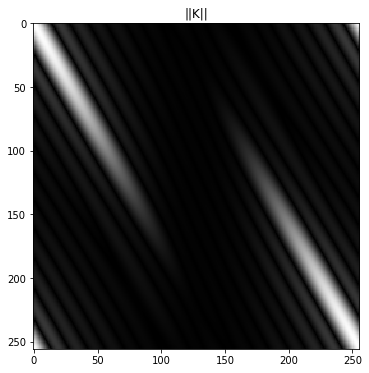

<Figure size 432x288 with 0 Axes>

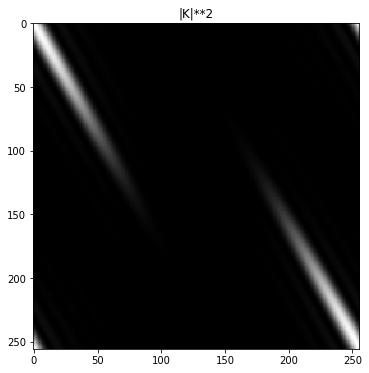

<Figure size 432x288 with 0 Axes>

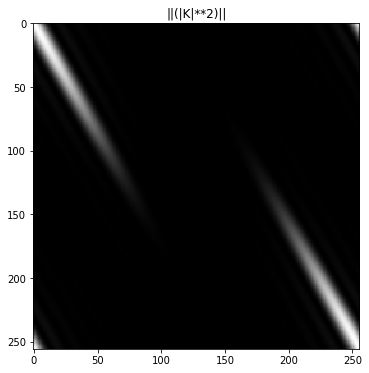

tracking <tf.Variable 'Variable:0' shape=(256, 256, 3) dtype=float32, numpy=
array([[[1.        , 1.        , 1.        ],
        [0.98344386, 0.98344386, 0.98344386],
        [0.93508756, 0.93508756, 0.93508756],
        ...,
        [0.8587279 , 0.8587279 , 0.8587279 ],
        [0.93508756, 0.93508756, 0.93508756],
        [0.98344386, 0.98344386, 0.98344386]],

       [[0.9944189 , 0.9944189 , 0.9944189 ],
        [0.99683356, 0.99683356, 0.99683356],
        [0.9663824 , 0.9663824 , 0.9663824 ],
        ...,
        [0.8044674 , 0.8044674 , 0.8044674 ],
        [0.89432603, 0.89432603, 0.89432603],
        [0.9593274 , 0.9593274 , 0.9593274 ]],

       [[0.9778254 , 0.9778254 , 0.9778254 ],
        [0.99913895, 0.99913895, 0.99913895],
        [0.9873834 , 0.9873834 , 0.9873834 ],
        ...,
        [0.74407434, 0.74407434, 0.74407434],
        [0.8451643 , 0.8451643 , 0.8451643 ],
        [0.9251256 , 0.9251256 , 0.9251256 ]],

       ...,

       [[0.9506636 , 0.9506636 , 0.95

<Figure size 432x288 with 0 Axes>

In [20]:
########################################################

# Build the model:

# initialization: x_0
y = Input(shape=image_shape)
x_0 = y

# initialization: C_0
# need any input as a placeholder for this layer (disconnected w/o this input)
c0 = C0(C_0=C_0)(y)

x_k = None
x_k_1 = None
for k in range(N):
    if k == 0:
        x_k = x_0
        cnn_net = createCNN(x_0, 
                            weight_decay, 
                            n=n, 
                            batchnorm_at_end=batchnorm_at_end)
    else:
        cnn_net = createCNN(x_k, 
                            weight_decay, 
                            n=n, 
                            batchnorm_at_end=batchnorm_at_end)

    if proximal_enabled:
        # Apply the custom ProximalGradient layer
        # - n in this case is the size of the image
        x_k_1 = ProximalGradient(blur_kernel=blur_kernel, 
                                 image_shape=image_shape,
                                 C_k=2**-k,
                                 verbose=k==0)([x_k, cnn_net, y, c0])

        # use x_{k+1} as the input to the next CNN in the loop
        x_k = x_k_1
    else:
        x_k = cnn_net

# create the model
model = Model(y, x_k_1 if proximal_enabled else x_k)
print(model.summary())

# write model summary to file
with open(os.path.join(runs_dir, "model_summary.txt"),"w") as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [0]:
# adding PSNR to list of metrics
if normalize:
    def PSNR(y_true, y_pred):
        max_pixel = 1.0
        return tf.image.psnr(y_true, y_pred, max_val=max_pixel)
    def PSNR_loss(y_true, y_pred):
        max_pixel = 1.0
        return -tf.image.psnr(y_true, y_pred, max_val=max_pixel)
else:
    def PSNR(y_true, y_pred):
        max_pixel = 255.0
        return tf.image.psnr(y_true, y_pred, max_val=max_pixel)
    def PSNR_loss(y_true, y_pred):
        max_pixel = 255.0
        return -tf.image.psnr(y_true, y_pred, max_val=max_pixel)

metrics = [PSNR]

In [0]:
# # compile the model with a loss function:

# # in order to use weight decay on all platforms, we define our own Adam Optimizer:
# # source: https://stackoverflow.com/questions/44452571/what-is-the-proper-way-to-weight-decay-for-adam-optimizer

# import re
# class AdamWeightDecayOptimizer(tf.train.Optimizer):
#     """
#     A basic Adam optimizer that includes "correct" L2 weight decay.
#     """

#     def __init__(self,
#                  learning_rate,
#                  weight_decay_rate=0.0,
#                  beta_1=0.9,
#                  beta_2=0.999,
#                  epsilon=1e-6,
#                  exclude_from_weight_decay=None,
#                  name="AdamWeightDecayOptimizer"):
#         """Constructs a AdamWeightDecayOptimizer."""

#         super(AdamWeightDecayOptimizer, self).__init__(False, name)

#         self.learning_rate = learning_rate
#         self.weight_decay_rate = weight_decay_rate
#         self.beta_1 = beta_1
#         self.beta_2 = beta_2
#         self.epsilon = epsilon
#         self.exclude_from_weight_decay = exclude_from_weight_decay

#     def apply_gradients(self, grads_and_vars, global_step=None, name=None):
#         """See base class."""

#         assignments = []
#         for (grad, param) in grads_and_vars:
#             if grad is None or param is None:
#                 continue

#             param_name = self._get_variable_name(param.name)

#             m = tf.get_variable(
#                 name=param_name + "/adam_m",
#                 shape=param.shape.as_list(),
#                 dtype=tf.float32,
#                 trainable=False,
#                 initializer=tf.zeros_initializer())
#             v = tf.get_variable(
#                 name=param_name + "/adam_v",
#                 shape=param.shape.as_list(),
#                 dtype=tf.float32,
#                 trainable=False,
#                 initializer=tf.zeros_initializer())

#             # Standard Adam update.
#             next_m = (
#                     tf.multiply(self.beta_1, m) + tf.multiply(1.0 - self.beta_1, grad))
#             next_v = (
#                     tf.multiply(self.beta_2, v) + tf.multiply(1.0 - self.beta_2,
#                                                             tf.square(grad)))

#             update = next_m / (tf.sqrt(next_v) + self.epsilon)

#             # Just adding the square of the weights to the loss function is *not*
#             # the correct way of using L2 regularization/weight decay with Adam,
#             # since that will interact with the m and v parameters in strange ways.
#             #
#             # Instead we want ot decay the weights in a manner that doesn't interact
#             # with the m/v parameters. This is equivalent to adding the square
#             # of the weights to the loss with plain (non-momentum) SGD.
#             if self._do_use_weight_decay(param_name):
#                 update += self.weight_decay_rate * param

#             update_with_lr = self.learning_rate * update

#             next_param = param - update_with_lr

#             assignments.extend(
#                 [param.assign(next_param),
#                 m.assign(next_m),
#                 v.assign(next_v)])
#         return tf.group(*assignments, name=name)

#     def _do_use_weight_decay(self, param_name):
#         """Whether to use L2 weight decay for `param_name`."""

#         if not self.weight_decay_rate:
#             return False
#         if self.exclude_from_weight_decay:
#             for r in self.exclude_from_weight_decay:
#                 if re.search(r, param_name) is not None:
#                     return False
#         return True

#     def _get_variable_name(self, param_name):
#         """Get the variable name from the tensor name."""

#         m = re.match("^(.*):\\d+$", param_name)
#         if m is not None:
#             param_name = m.group(1)
#         return param_name

In [23]:
# compile the model with a loss function:

# define exponential decay:
initial_learning_rate = learning_rate
# decay_steps = 1.2e6 * 0.25 # assumed 1 epoch == 1.2e6 int(len(images['train']) * 0.25 / batch_size)
decay_steps = len(images['train']) * 100 # decay 50% by 100 epochs
print('Compiled with exponential decay with decay_steps={}'.format(decay_steps))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.5,
    staircase=False)

# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
adam = tfa.optimizers.AdamW(learning_rate=lr_schedule, beta_1=beta_1, beta_2=beta_2, weight_decay=weight_decay)
# adam = AdamWeightDecayOptimizer(learning_rate, beta_1=beta_1, beta_2=beta_2, weight_decay_rate=weight_decay)
model.compile(loss='mean_squared_error', metrics=metrics, optimizer=adam)

Compiled with exponential decay with decay_steps=20000


In [0]:
########################################################

# Training the model

# define the generators:
training_generator = ImageGenerator(train_dir, train_dir, batch_size, sigma_=noise_sigma, blur_kernel_=blur_kernel, crop_size=image_shape[0], normalize=normalize)
validation_generator = ImageGenerator(val_dir, val_dir, batch_size, sigma_=noise_sigma, blur_kernel_=blur_kernel, crop_size=image_shape[0], normalize=normalize)

In [25]:
########################################################

# Add logger and checkpointer

def tensorboard():
    # starting tensorboard: tensorboard --logdir=run1:logs/ --port 6006
    print('--- enabling TensorBoard')
    return TensorBoard(log_dir=logs_dir, histogram_freq=0, 
                       write_graph=True, write_images=True)

def checkpointer():
    print('--- enabling Checkpointer')
    return ModelCheckpoint(filepath=os.path.join(model_dir, 'e{epoch:002d}.h5'), 
                           monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=1)

callbacks = [checkpointer(), tensorboard()]

--- enabling Checkpointer
--- enabling TensorBoard


In [26]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              use_multiprocessing=use_multiprocessing,
                              workers=workers,
                              callbacks=callbacks,
                              verbose=1)

# save history as pickle file:
with open(os.path.join(runs_dir, 'history.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
50/50 [==============================] - 50s 999ms/step - loss: 0.2497 - PSNR: 8.9512 - val_loss: 0.1261 - val_PSNR: 8.4295


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/300
50/50 [==============================] - 33s 657ms/step - loss: 0.0390 - PSNR: 14.5789 - val_loss: 0.1010 - val_PSNR: 10.2190
Epoch 3/300
50/50 [==============================] - 33s 662ms/step - loss: 0.0218 - PSNR: 17.0264 - val_loss: 0.0539 - val_PSNR: 11.5404
Epoch 4/300
50/50 [==============================] - 33s 664ms/step - loss: 0.0159 - PSNR: 18.3827 - val_loss: 0.0599 - val_PSNR: 12.8712
Epoch 5/300
50/50 [==============================] - 33s 666ms/step - loss: 0.0123 - PSNR: 19.5119 - val_loss: 0.0287 - val_PSNR: 14.3494
Epoch 6/300
50/50 [==============================] - 33s 665ms/step - loss: 0.0106 - PSNR: 20.2509 - val_loss: 0.0246 - val_PSNR: 15.8051
Epoch 7/300
50/50 [==============================] - 33s 664ms/step - loss: 0.0096 - PSNR: 20.6714 - val_loss: 0.0216 - val_PSNR: 16.7664
Epoch 8/300
50/50 [==============================] - 33s 666ms/step - loss: 0.0092 - PSNR: 20.8410 - val_loss: 0.0183 - val_PSNR: 17.9137
Epoch 9/300
50/50 [===============

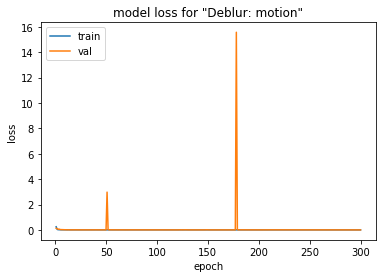

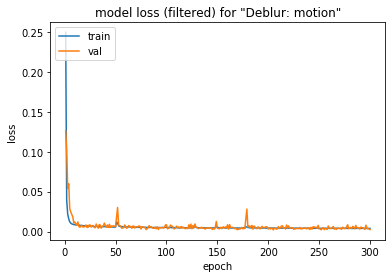

In [27]:
# # summarize history for loss
plt.plot([x + 1 for x in range(len(history.history['loss']))], history.history['loss'])
plt.plot([x + 1 for x in range(len(history.history['val_loss']))], history.history['val_loss'])
plt.title('model loss for "Deblur: {}"'.format(blur_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_loss'))
plt.show()

# # summarize history for loss (filtered)
plt.plot([idx + 1 for idx, x in enumerate(history.history['loss']) if x < 1], [x for x in history.history['loss'] if x < 1])
plt.plot([idx + 1 for idx, x in enumerate(history.history['val_loss']) if x < 1], [x for x in history.history['val_loss'] if x < 1])
plt.title('model loss (filtered) for "Deblur: {}"'.format(blur_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_loss_f'))
plt.show()

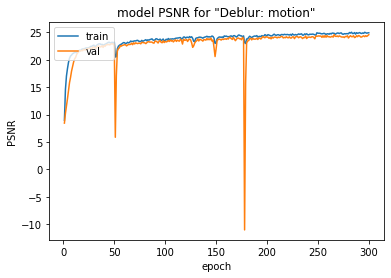

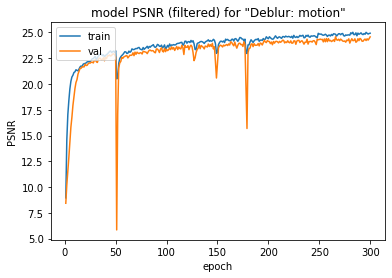

In [28]:
# # summarize history for PSNR
plt.plot([x + 1 for x in range(len(history.history['PSNR']))], history.history['PSNR'])
plt.plot([x + 1 for x in range(len(history.history['val_PSNR']))], history.history['val_PSNR'])
plt.title('model PSNR for "Deblur: {}"'.format(blur_name))
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_psnr'))
plt.show()

# # summarize history for PSNR (filtered)
plt.plot([idx + 1 for idx, x in enumerate(history.history['PSNR']) if x > 0], [x for x in history.history['PSNR'] if x > 0])
plt.plot([idx + 1 for idx, x in enumerate(history.history['val_PSNR']) if x > 0], [x for x in history.history['val_PSNR'] if x > 0])
plt.title('model PSNR (filtered) for "Deblur: {}"'.format(blur_name))
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(figs_dir, 'model_psnr_f'))
plt.show()

In [29]:
# serialize weights to HDF5
print("Saving model to disk (_e{0:002d}.h5)".format(epochs))
model.save_weights(os.path.join(model_dir, "_e{0:002d}.h5".format(epochs)))

Saving model to disk (_e300.h5)


In [30]:
# load the best-performing model:
# model_weights = [int(x[1:][:2]) for x in os.listdir(model_dir) if "_e" not in x]
model_weights = [] # use latest training episode
if len(model_weights) == 0:
    best_weight = "_e{0:002d}.h5".format(epochs)
else:
    model_weights = sorted(model_weights)
    best_weight = "e{0:002d}.h5".format(model_weights[-1])

print("Loading weights from '{}'".format(os.path.join(model_dir, best_weight)))
model.load_weights(os.path.join(model_dir, best_weight))

Loading weights from '/content/gdrive/My Drive/239ASCompImagingData/runs/deblurring-motion/run-19/model/_e300.h5'


In [0]:
# evaluate the network
# NOTE: we are not using the noisy sets, just blurring the original images

def evaluate_model(eval_type='test', seed=1):

    print('='*30)
    print('Evaluating using {} set'.format(eval_type))

    # make a folder to place eval results into
    eval_dir = os.path.join(runs_dir, '{}_evaluation'.format(eval_type))
    print(eval_dir)
    if not os.path.exists(eval_dir):
        os.mkdir(eval_dir)

    # define blurring ops:
    def apply_blur(x):
        x_blurred = [scipy.ndimage.convolve(x[..., c], blur_kernel, mode='constant') for c in range(x.shape[2])]
        x_blurred = np.stack(x_blurred)
        x_blurred = np.moveaxis(x_blurred, 0, -1)
        return x_blurred

    # image blurring
    x_set = [apply_blur(x.astype('float32')) for x in tqdm(images[eval_type])]
    y_set = images[eval_type]

    # image cropping
    crop_this = iaa.Sequential([
        iaa.CropToFixedSize(width=image_shape[0], height=image_shape[1], position="uniform")
    ])
    ia.seed(seed)
    x_input = np.array(crop_this(images=x_set))
    ia.seed(seed)
    y_input = np.array(crop_this(images=y_set))

    # normalize
    if normalize:
        x_input = x_input.astype('float32')
        x_input = x_input / 255.0

        y_input = y_input.astype('float32')
        y_input = y_input / 255.0

    # model evals
    x_hat = model.predict(x_input)
    errors = model.evaluate(x_input, y_input)
    print('PSNR of model evaluated on {} set: {}'.format(eval_type, errors[1]))
    print('Loss of model evaluated on {} set: {}'.format(eval_type, errors[0]))

    with open(os.path.join(runs_dir, 'evaluation_summary.txt'), 'a+') as eval_txt:
        print('PSNR of model evaluated on {} set: {}\n'.format(eval_type, errors[1]), file=eval_txt)
        print('Loss of model evaluated on {} set: {}\n'.format(eval_type, errors[0]), file=eval_txt)
        print('\n', file=eval_txt)

    # export results on data
    def show_results(i=0):
        result_dir = os.path.join(eval_dir, 'sample-{}'.format(i))
        if not os.path.exists(result_dir):
            os.mkdir(result_dir)

        showImage(x_input[i], normalized=normalize, title="x_input example {}".format(i), saveto=os.path.join(result_dir, 'x_input_ex{}'.format(i)))
        showImage(x_hat[i], normalized=normalize, title="x_hat example {}".format(i), saveto=os.path.join(result_dir, 'x_hat_ex{}'.format(i)))
        showImage(y_input[i], normalized=normalize, title="y_input example {}".format(i), saveto=os.path.join(result_dir, 'y_input_ex{}'.format(i)))

    show_results(0)
    print('-'*100)
    show_results(90)
    print('-'*100)
    show_results(99)

    print('=' * 30)
    print()

  2%|▏         | 4/200 [00:00<00:05, 33.01it/s]

Evaluating using train set
/content/gdrive/My Drive/239ASCompImagingData/runs/deblurring-motion/run-19/train_evaluation


100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


200/200 [==============================] - 8s 39ms/step
PSNR of model evaluated on train set: 25.396621704101562
Loss of model evaluated on train set: 0.0035431787185370924


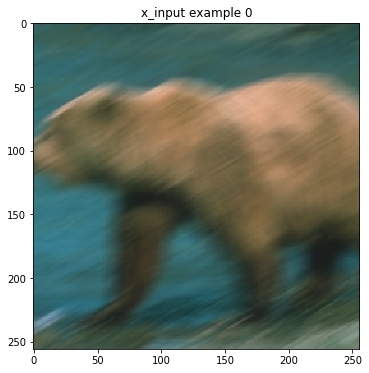

<Figure size 432x288 with 0 Axes>

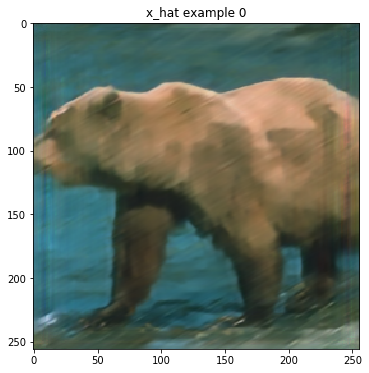

<Figure size 432x288 with 0 Axes>

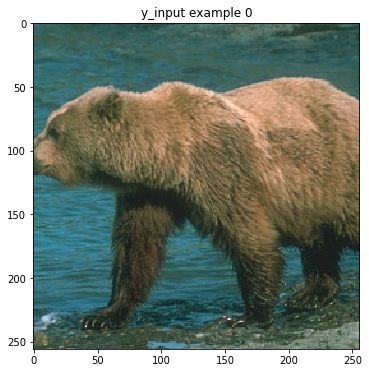

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

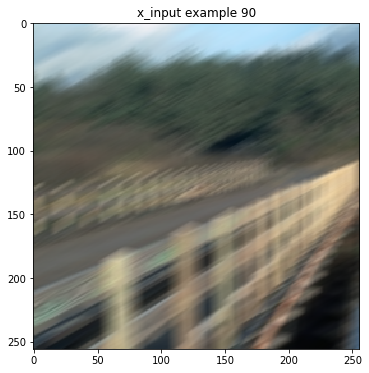

<Figure size 432x288 with 0 Axes>

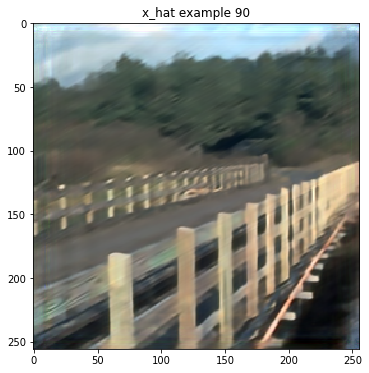

<Figure size 432x288 with 0 Axes>

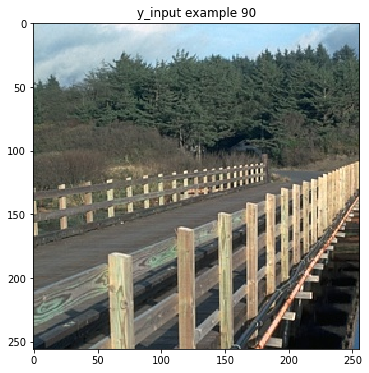

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

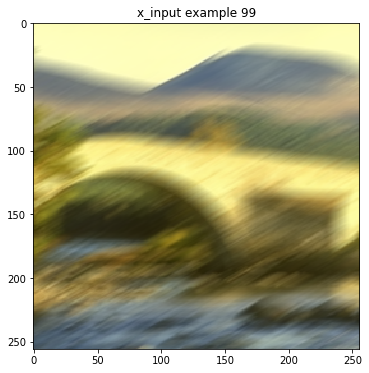

<Figure size 432x288 with 0 Axes>

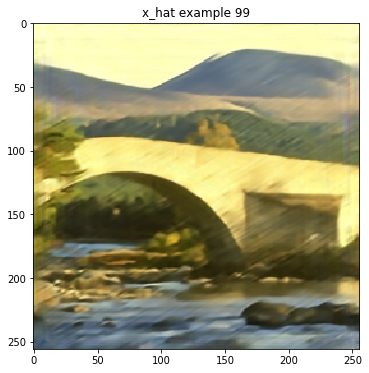

<Figure size 432x288 with 0 Axes>

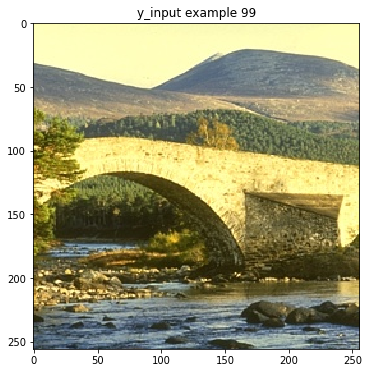

  0%|          | 0/100 [00:00<?, ?it/s]


Evaluating using val set
/content/gdrive/My Drive/239ASCompImagingData/runs/deblurring-motion/run-19/val_evaluation


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


100/100 [==============================] - 4s 39ms/step
PSNR of model evaluated on val set: 24.925390243530273
Loss of model evaluated on val set: 0.0038600912503898143


<Figure size 432x288 with 0 Axes>

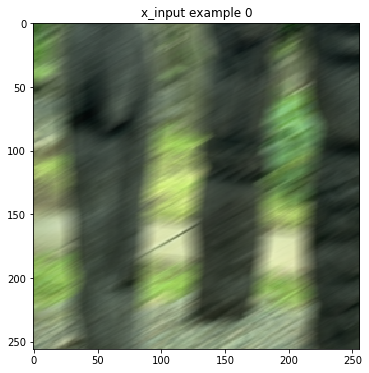

<Figure size 432x288 with 0 Axes>

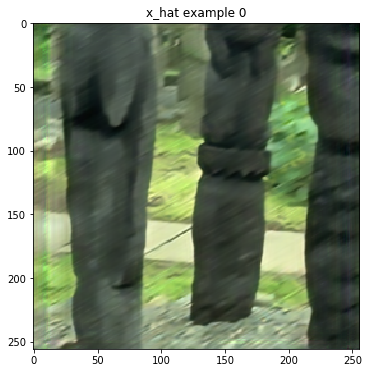

<Figure size 432x288 with 0 Axes>

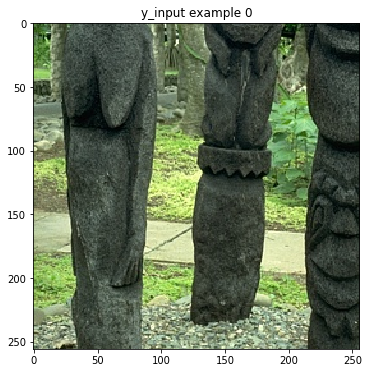

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

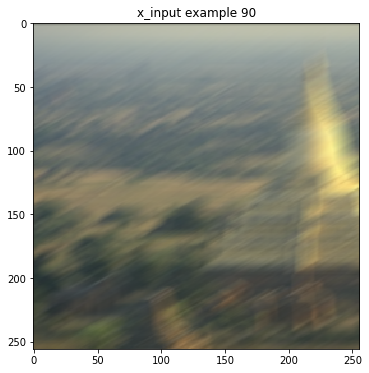

<Figure size 432x288 with 0 Axes>

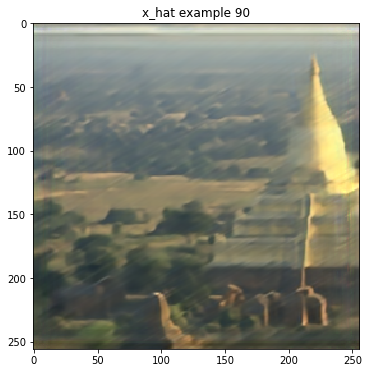

<Figure size 432x288 with 0 Axes>

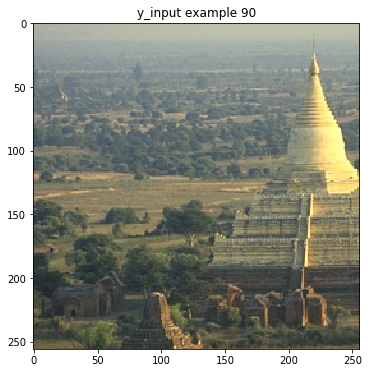

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

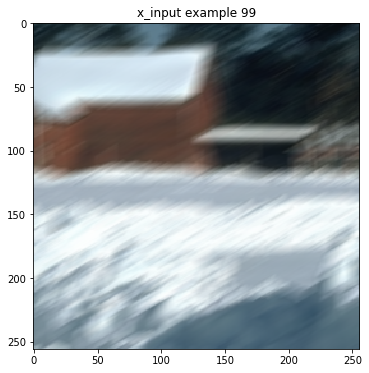

<Figure size 432x288 with 0 Axes>

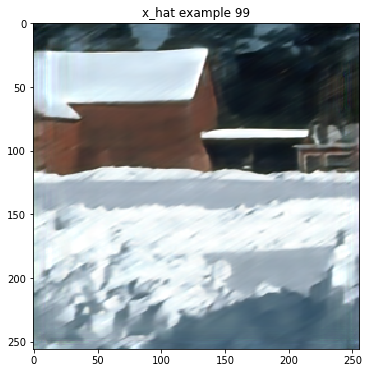

<Figure size 432x288 with 0 Axes>

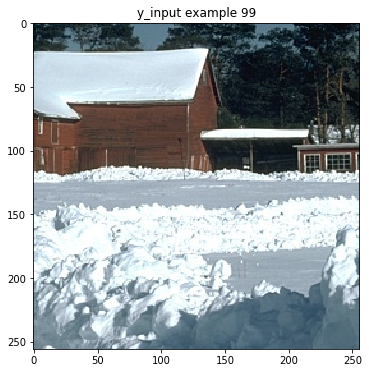

  2%|▏         | 4/200 [00:00<00:05, 34.05it/s]


Evaluating using test set
/content/gdrive/My Drive/239ASCompImagingData/runs/deblurring-motion/run-19/test_evaluation


100%|██████████| 200/200 [00:05<00:00, 35.32it/s]


200/200 [==============================] - 8s 39ms/step
PSNR of model evaluated on test set: 24.88616943359375
Loss of model evaluated on test set: 0.0038490396738052367


<Figure size 432x288 with 0 Axes>

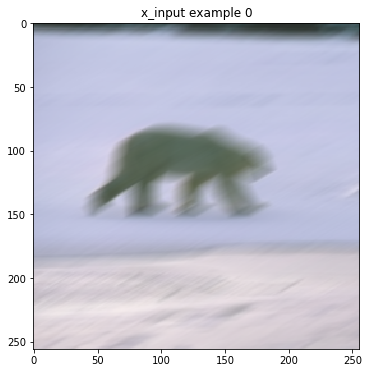

<Figure size 432x288 with 0 Axes>

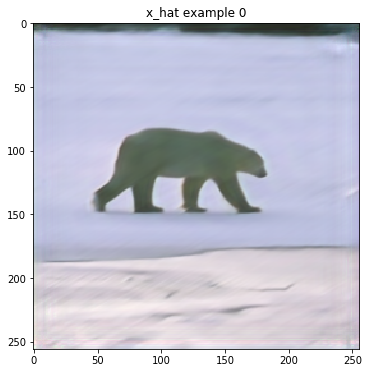

<Figure size 432x288 with 0 Axes>

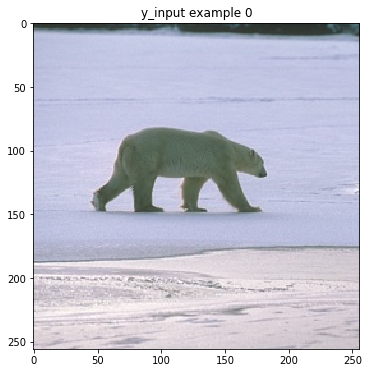

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

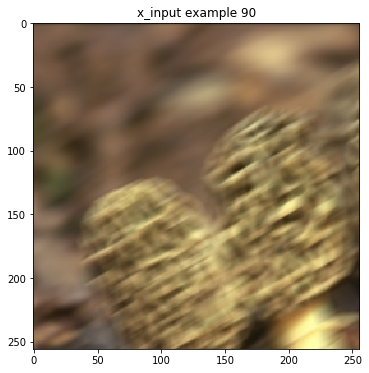

<Figure size 432x288 with 0 Axes>

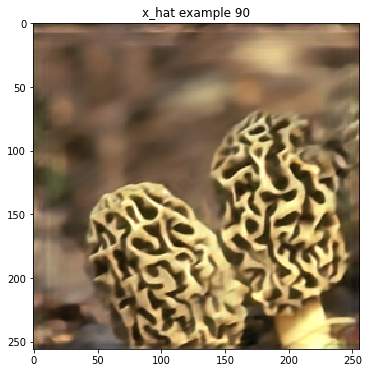

<Figure size 432x288 with 0 Axes>

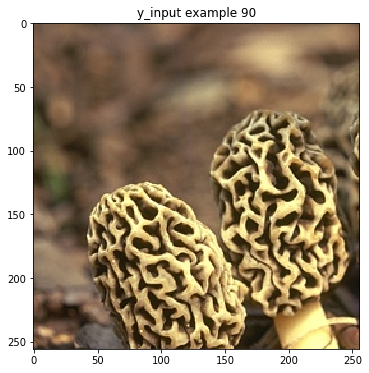

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

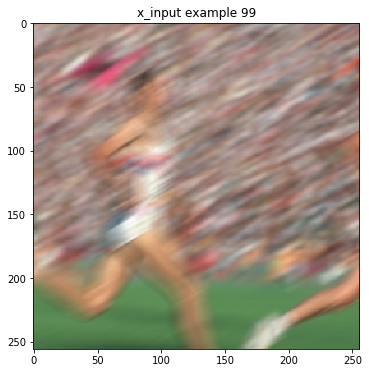

<Figure size 432x288 with 0 Axes>

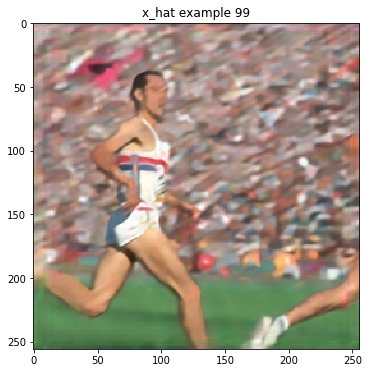

<Figure size 432x288 with 0 Axes>

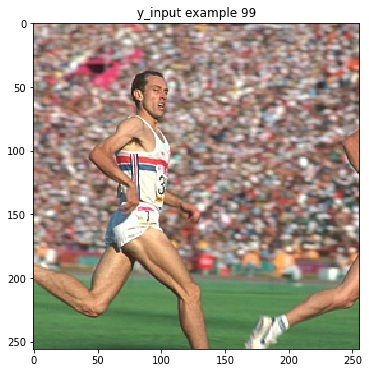

<Figure size 432x288 with 0 Axes>

In [32]:
# gather data of the best model for all datasets
evaluate_model('train')
evaluate_model('val')
evaluate_model('test')